<a href="https://colab.research.google.com/github/ZeyadSabbah/TrivagoRecommenderSystem/blob/master/TrivagoEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Trivago/

/content/drive/My Drive/Trivago


# Loading Libraries & Datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
item_metadata_filepath = './Datasets/raw_data/item_metadata.csv'
submission_popular_filepath = './Datasets/raw_data/submission_popular.csv'
train_filepath = './Datasets/raw_data/train.csv'
test_filepath = './Datasets/raw_data/test.csv'

submission_popular = pd.read_csv(submission_popular_filepath)
item_metadata = pd.read_csv(item_metadata_filepath)
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

# Understanding Different Datasets

## train

In [5]:
train.shape

(15932992, 12)

In [6]:
train.dtypes

user_id            object
session_id         object
timestamp           int64
step                int64
action_type        object
reference          object
platform           object
city               object
device             object
current_filters    object
impressions        object
prices             object
dtype: object

In [7]:
train.tail()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
15932987,ZYNMLE3MV3LK,62728015bec05,1541544490,15,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932988,ZYNMLE3MV3LK,62728015bec05,1541544491,16,clickout item,6617798,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932989,ZYNMLE3MV3LK,62728015bec05,1541544540,17,clickout item,2712342,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932990,ZYNMLE3MV3LK,62728015bec05,1541544967,18,change of sort order,interaction sort button,PT,"Paris, France",desktop,NaN,NaN,NaN
15932991,ZYNMLE3MV3LK,62728015bec05,1541544973,19,clickout item,1161323,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...


Final Clickout in each session represented in action_type attribute is the most important step for the click through rate. Any session can contain zero, one, or many clickouts, though.Trivago concentrates at this for the profit calculation. All features required to be engineered is based on predicting the final click out action.  
Each user has an id, each user can have one or more seperate sessions. There is a recorded timestamp for each step the user is taking on the website or on the app, and steps are counted in each session through the count going from one till the end when the user leaves the session.  
The step can be anything from checking a rating to viewing an image to changing an order of the list to other actions that has to do with items (accomodations).
Accomodations have ids shown in reference attribute, these accomodations are displayed to the user in the form of list, and the list can vary from just one item up to 25 items.  
The shown items are put in a string seperated by a pipe in the impressions attribute, matching this order is the prices list seperated by a pipe as well in the prices attribute. (These two attributes do not have a value unless the action_type attribute is 'clickout'.  
The platform attribute contains the location from where the user is checking the website or the app, while the city is the location where they are looking for the accomodation in, and device shows which device they are actually using.  
The current_fiters attribute shows what the filters the user has specified in their search for the suitable accomodation to themselves.

## test

In [8]:
test.shape

(3782335, 12)

In [9]:
test.dtypes

user_id            object
session_id         object
timestamp           int64
step                int64
action_type        object
reference          object
platform           object
city               object
device             object
current_filters    object
impressions        object
prices             object
dtype: object

In [10]:
test.tail(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
3782334,ZZCM39YKI3NR,6226bde1465e7,1541601178,1,clickout item,NaN,IT,"Dublin, Ireland",mobile,NaN,46149|109974|46119|8333280|12455|1185556|84002...,138|138|156|153|128|202|145|137|105|68|133|167...


The NaN value shown in reference is actually the label hidden away. That represents what needs to be predicted or in another way that's what needs to be put in a list and Trivago is considered to do better if this item was on the top of the list provided to the user.

## submission_popular

This is the form on how the test set predictions should be submitted.

In [11]:
submission_popular.head(2)

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...


Taking a session as an example to understand what is being represented in the submission_popular dataset in relation with test set.

In [12]:
test[test.session_id=='9de47d9a66494']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1030763,0004Q49X39PY,9de47d9a66494,1541641157,1,clickout item,NaN,PH,"Iloilo City, Philippines",mobile,NaN,2213014|3184842|10213134|4504242|4486372|38120...,53|40|112|57|76|29|42|37|66|66|26|43|28|46|28|...


If we take a look at the impressions of this session at the test set, and the item_recommendations in submission_popular, we will find that they are the same items, only with difference in the order and also the seperator.

In [13]:
test_impressions = test[test.session_id=='9de47d9a66494'].impressions.values[0].split('|')
item_recommendations = submission_popular[submission_popular.session_id=='9de47d9a66494'].item_recommendations.values[0].split(' ')

sorted(test_impressions) == sorted(item_recommendations)

True

## item_metadata

In [14]:
item_metadata.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


The item_metadata set contains the properties for each item id (mentioned before in reference attributes in other datasets). The properties are also seperated by a pipe and in the string format.

# Research Questions

**What is the timeline of the training and test sets?**

In [15]:
from datetime import datetime

latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()
print(datetime.fromtimestamp(latest_timestamp) - datetime.fromtimestamp(earliest_timestamp))

5 days, 23:59:51


In [16]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()
print(datetime.fromtimestamp(latest_timestamp) - datetime.fromtimestamp(earliest_timestamp))

1 day, 23:59:52


The training data is gathered over 6 days, while the test data is over 2 days.

**Which days, month, and year this data is gathered over?**

In [17]:
latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

print(earliest_date)
print(latest_date)

2018-11-01 00:00:08
2018-11-06 23:59:59


In [18]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

print(earliest_date)
print(latest_date)

2018-11-07 00:00:07
2018-11-08 23:59:59


The train and test sets are over 8 consecutive days.

**What days of the week for the train and test sets?**

In [19]:
from datetime import date
import calendar

latest_timestamp = train.timestamp.max()
earliest_timestamp = train.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

first_day = calendar.day_name[earliest_date.weekday()]
last_day = calendar.day_name[latest_date.weekday()]
print(first_day)
print(last_day)

Thursday
Tuesday


In [20]:
latest_timestamp = test.timestamp.max()
earliest_timestamp = test.timestamp.min()

latest_date = datetime.fromtimestamp(latest_timestamp)
earliest_date = datetime.fromtimestamp(earliest_timestamp)

first_day = calendar.day_name[earliest_date.weekday()]
last_day = calendar.day_name[latest_date.weekday()]
print(first_day)
print(last_day)

Wednesday
Thursday


**What is the distribution of the number of steps in sessions?**

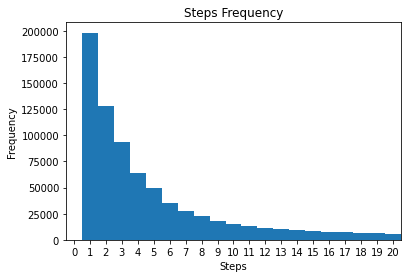

In [21]:
bin_size = 1
sessions_steps = train.groupby('session_id', sort=False).timestamp.count()
bin_edges = np.arange(0, sessions_steps.max() + bin_size, bin_size)
x_locs = np.arange(0, 21, 1) + 0.5
x_labels = np.arange(0, 21, 1)

plt.hist(sessions_steps, bins=bin_edges)
plt.xticks(x_locs, x_labels)
plt.xlim([0, 21])
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.title('Steps Frequency')
plt.show()

The number of steps is right skewed, an interesting observation is that there is actually many sessions with only one step.

**What is the duration distribution of sessions?**

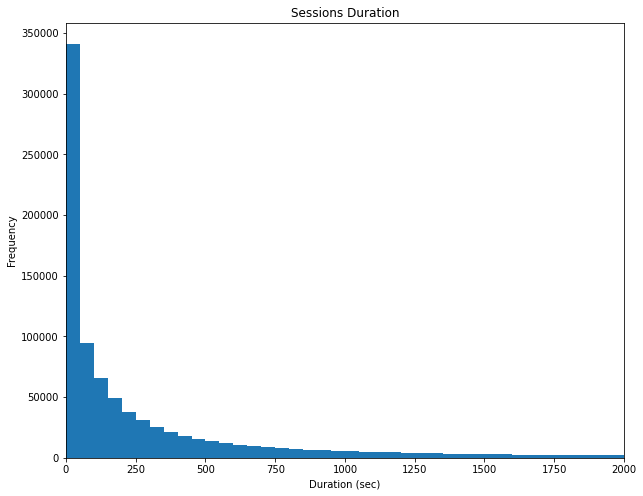

In [26]:
sessions_duration = train.groupby('session_id', sort=False).timestamp.max() - train.groupby('session_id', sort=False).timestamp.min()
bin_size = 50
bin_edges = np.arange(0, 2000 + bin_size, bin_size)

plt.figure(figsize=[10, 8])
plt.hist(sessions_duration, bins=bin_edges)
plt.xlim([0, 2000])
plt.xlabel('Duration (sec)')
plt.ylabel('Frequency')
plt.title('Sessions Duration')
plt.show()

The data is right skewed. Logarithmic transformation would be much of a help in this case.

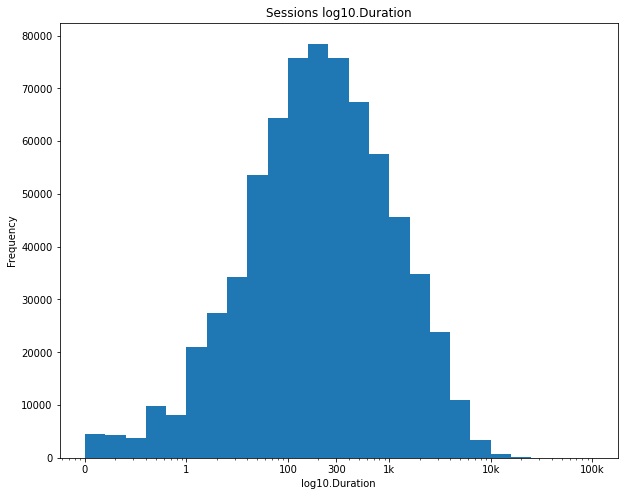

In [34]:
bin_size = 0.2
bin_edges = 10 ** np.arange(0, 5 + bin_size, bin_size)

plt.figure(figsize=[10, 8])
plt.hist(sessions_duration, bins=bin_edges)
x_locs = [1e0, 1e1, 1e2, 3e2, 1e3, 1e4, 1e5]
x_labels = ['0', '1', '100', '300', '1k', '10k', '100k']
plt.xscale('log')
plt.xticks(x_locs, x_labels)
plt.xlabel('log10.Duration')
plt.ylabel('Frequency')
plt.title('Sessions log10.Duration')
plt.show()

**What is the action distribution?**

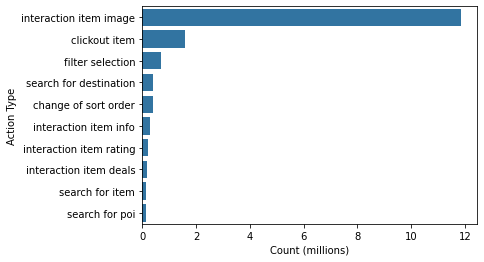

In [44]:
action_type_order = train.action_type.value_counts().index
base_color = sns.color_palette()[0]
sns.countplot(data=train, y='action_type', color=base_color, order=action_type_order)
x_locs = [0, 0.2e7, 0.4e7, 0.6e7, 0.8e7, 1e7, 1.2e7]
x_labels = ['0', '2', '4', '6', '8', '10', '12']
plt.xlabel('Count (millions)')
plt.ylabel('Action Type')
plt.xticks(x_locs, x_labels)
plt.show()

It seems like users like to check for the images of the accomodations the most. Disregarding the 'interation item image' to check the other attributes values. 'clickout item' comes second.

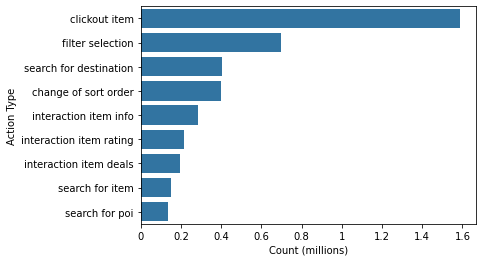

In [46]:
action_type_order = train[train.action_type!='interaction item image'].action_type.value_counts().index
base_color = sns.color_palette()[0]
sns.countplot(data=train, y='action_type', color=base_color, order=action_type_order)
x_locs = [0, 0.2e6, 0.4e6, 0.6e6, 0.8e6, 1e6, 1.2e6, 1.4e6, 1.6e6]
x_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4', '1.6']
plt.xlabel('Count (millions)')
plt.ylabel('Action Type')
plt.xticks(x_locs, x_labels)
plt.show()

**What is the distribution of the platforms used?**

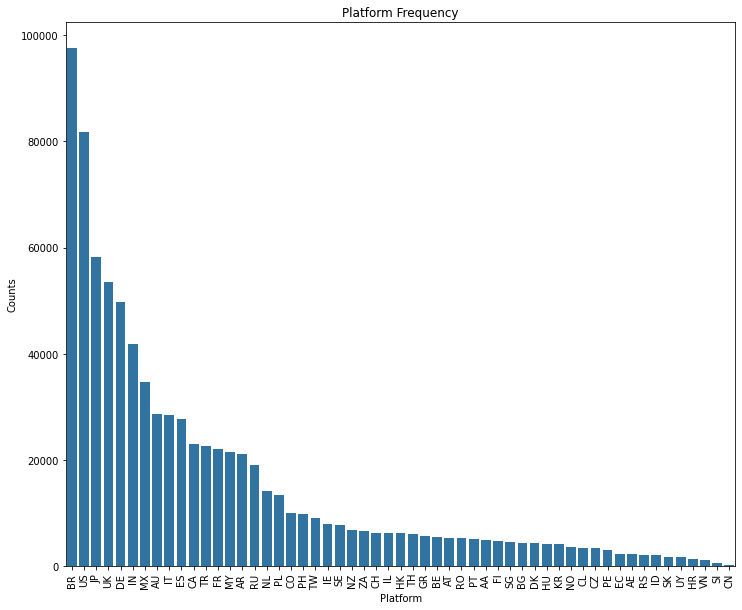

In [51]:
clickout_df = train[train.action_type=='clickout item'].groupby('session_id', sort=False).tail(1)
platform_order = clickout_df.platform.value_counts().index
plt.figure(figsize=[12, 10])
sns.countplot(data=clickout_df, x='platform', color=base_color, order=platform_order)
plt.title('Platform Frequency')
plt.xlabel('Platform')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

This shows that the highest number of users are from Brazil, comes second United States, and so on.

**What is the distribution of the worlds' accomodations selected?**

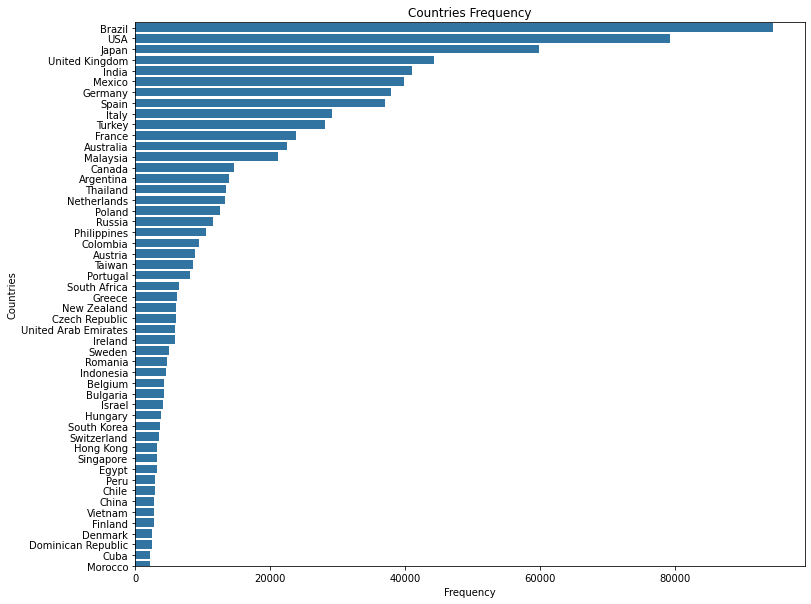

In [67]:
countries = clickout_df.city.apply(lambda x: x.split(',')[1]).apply(lambda x: x.strip())
countries_order = countries.value_counts().index

plt.figure(figsize=[12, 10])
sns.countplot(y=countries, color=base_color, order=countries_order)
plt.ylim(50)
plt.xlabel('Frequency')
plt.ylabel('Countries')
plt.title('Countries Frequency')
plt.show()

The highest countries in terms of accomodations' booking are Brazil, then United Kingdom, and so on.

**What is the traffic across the week?**

In [77]:
clickout_df['date_time'] = clickout_df.timestamp.apply(lambda x: datetime.fromtimestamp(x))
clickout_df['day_of_week'] = clickout_df.date_time.apply(lambda x: calendar.day_name[x.weekday()])
clickout_df.head(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,date_time,day_of_week
15,00RL8Z82B2Z1,aff3928535f48,1541038485,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,55109|129343|54824|2297972|109014|1257342|1031...,162|25|150|143|101|49|118|131|18|100|101|143|5...,2018-11-01 02:14:45,Thursday


In [84]:
day_of_week_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
week = pd.api.types.CategoricalDtype(categories=day_of_week_order, ordered=True)
day_of_week[]
clickout_df.groupby('day_of_week').session_id.count()

day_of_week
Friday      132126
Monday      146582
Saturday    125188
Sunday      140455
Thursday    137190
Tuesday     145301
Name: session_id, dtype: int64

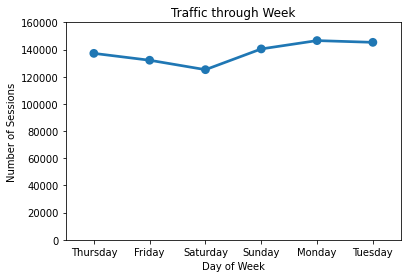

In [91]:
day_of_week_order = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
sessions_day = clickout_df.groupby('day_of_week').session_id.count()
sns.pointplot(x=sessions_day.index, y=sessions_day.values, order=day_of_week_order)
plt.ylim([0, 160000])
plt.ylabel('Number of Sessions')
plt.xlabel('Day of Week')
plt.title('Traffic through Week')
plt.show()

Users might be more active, and there might be more traffic at the start of the week going on.